# Introduction to Computer Vision: Plant Seedlings Classification

## Problem Statement

### Context

In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term. The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can actually benefit the workers in this field, as **the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning.** The ability to do so far more efficiently and even more effectively than experienced manual labor, could lead to better crop yields, the freeing up of human inolvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.


### Objective

The aim of this project is to Build a Convolutional Neural Netowrk to classify plant seedlings into their respective categories.

### Data Dictionary

The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has recently released a dataset containing **images of unique plants belonging to 12 different species.**

- The dataset can be download from Olympus.
- The data file names are:
    - images.npy
    - Labels.csv
- Due to the large volume of data, the images were converted to the images.npy file and the labels are also put into Labels.csv, so that you can work on the data/project seamlessly without having to worry about the high data volume.

- The goal of the project is to create a classifier capable of determining a plant's species from an image.

**List of Species**

- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common Wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet

## Importing necessary libraries

In [44]:
!python --version

Python 3.11.11


In [45]:
!pip install tensorflow==2.17 scikit-learn==1.3.2 seaborn==0.13.1 matplotlib==3.8.0 numpy==1.26.4 pandas==2.2.2 opencv-python==4.8.0.76 -q --user

**Note**: *After running the above cell, kindly restart the notebook kernel and run all cells sequentially from the start again.*

In [46]:
import os
import numpy as np                                                                               # Importing numpy for Matrix Operations
import pandas as pd                                                                              # Importing pandas to read CSV files
import matplotlib.pyplot as plt                                                                  # Importting matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2                                                                                       # Importing openCV for image processing
import seaborn as sns                                                                            # Importing seaborn to plot graphs


# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam,SGD                                                 # Importing the optimizers which can be used in our model
from sklearn import preprocessing                                                                # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix                                                     # Importing confusion_matrix to plot the confusion matrix
from sklearn.preprocessing import LabelBinarizer
# Display images using OpenCV
from google.colab.patches import cv2_imshow                                                      # Importing cv2_imshow from google.patches to display images
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend
from keras.callbacks import ReduceLROnPlateau
import random
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Loading the dataset

In [47]:
# Load the image file of dataset
images = np.load('/content/images.npy')
# Load the labels file of dataset
labels = pd.read_csv('/content/Labels.csv')

## Data Overview

### Understand the shape of the dataset

In [48]:
print(images.shape)
print(labels.shape)

(4750, 128, 128, 3)
(4750, 1)


The dataset contains 4750 RGB images of the shape 128*128 pixels, each containing 3 channels

In [49]:
labels.sample(n=5)

,Label
2169,Charlock
3950,Black-grass
3968,Black-grass
1678,Common Chickweed
393,Small-flowered Cranesbill


## Exploratory Data Analysis

### Plotting random images from each of the class

In [50]:
def plot_images(images,labels):
  num_classes=10                                                                  # Number of Classes
  categories=np.unique(labels)
  keys=dict(labels['Label'])                                                      # Obtaing the unique classes from y_train
  rows = 3                                                                        # Defining number of rows=3
  cols = 4                                                                        # Defining number of columns=4
  fig = plt.figure(figsize=(10, 8))                                               # Defining the figure size to 10x8
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))                        # Generating random indices from the data and plotting the images
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
          ax.imshow(images[random_index, :])                                      # Plotting the image
          ax.set_title(keys[random_index])
  plt.show()

In [51]:
labels.value_counts()

,count
Label,
Loose Silky-bent,654
Common Chickweed,611
Scentless Mayweed,516
Small-flowered Cranesbill,496
Fat Hen,475
Charlock,390
Sugar beet,385
Cleavers,287
Black-grass,263


* 2 plants, "Loose Silky-bent" and "Common Chickweed" comprose over a quarter (~26%) of all images
* 5 plants with most images comprise 58% of all images
* The number of images for each plant ranges from 221 to 654, close to 3 times more images for the model to train with
* Since the distribution of the number of images for each plant is not uniform, there is potential for CNN model to overfit


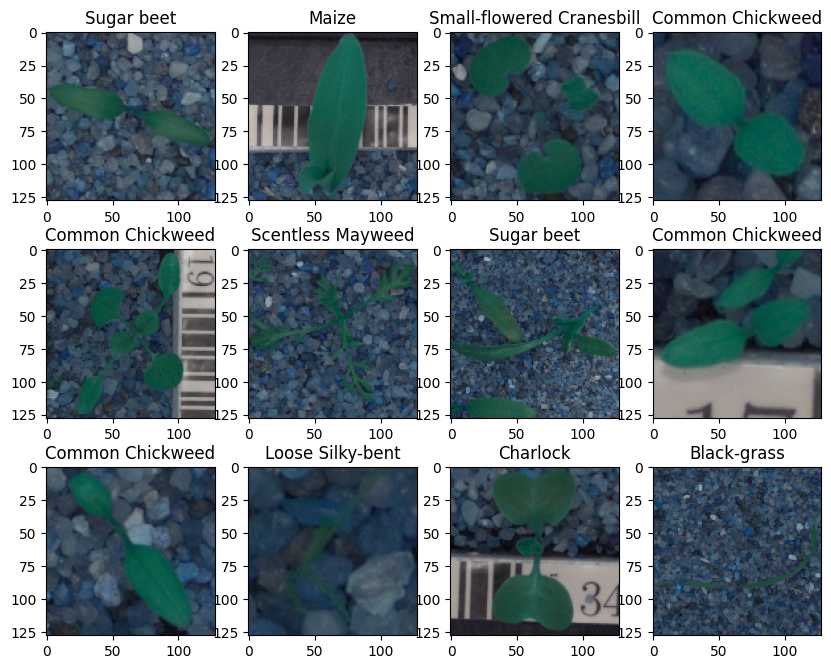

In [52]:
plot_images(images,labels)

* All of the plants appear to be various shapes and shades of green in a blue, rocky soil

### Checking the distribution of the target variable

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, 'Small-flowered Cranesbill'),
  Text(1, 0, 'Fat Hen'),
  Text(2, 0, 'Shepherds Purse'),
  Text(3, 0, 'Common wheat'),
  Text(4, 0, 'Common Chickweed'),
  Text(5, 0, 'Charlock'),
  Text(6, 0, 'Cleavers'),
  Text(7, 0, 'Scentless Mayweed'),
  Text(8, 0, 'Sugar beet'),
  Text(9, 0, 'Maize'),
  Text(10, 0, 'Black-grass'),
  Text(11, 0, 'Loose Silky-bent')])

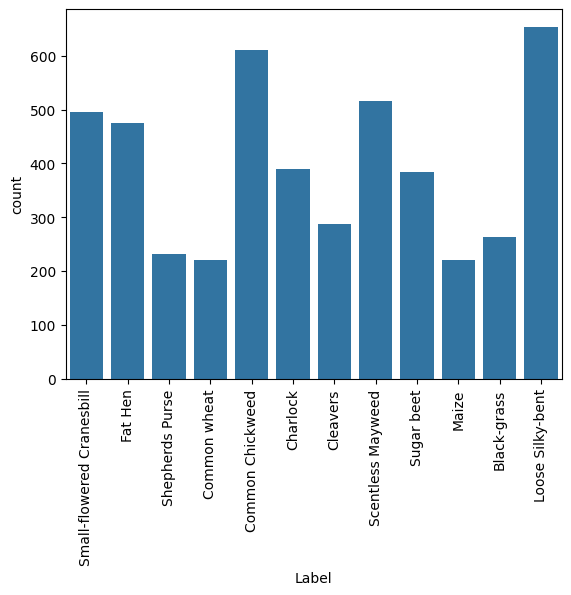

In [53]:
sns.countplot(x=labels['Label'])
plt.xticks(rotation='vertical')

## Data Pre-Processing

### Converting the BGR images to RGB images.

In [54]:
# Converting the images from BGR to RGB using cvtColor function of OpenCV
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

### Resizing images

As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

In [55]:
images_decreased=[]
height = 64
width =  64
for i in range(len(images)):
  images_decreased.append( cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))

**Image before resizing**

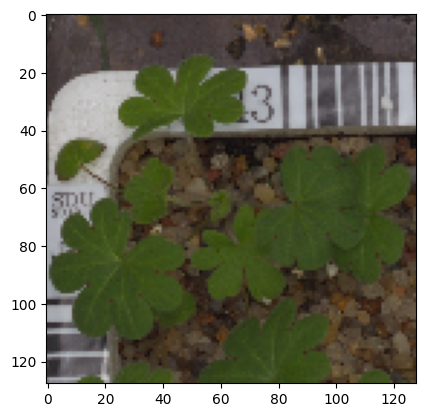

In [56]:
plt.imshow(images[3])

**Image after resizing**

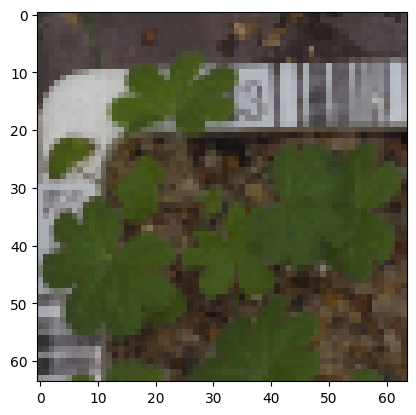

In [57]:
plt.imshow(images_decreased[3])

### Data Preparation for Modeling


- As we have less images in our dataset, we will only use 10% of our data for testing, 10% of our data for validation and 80% of our data for training.
- We are using the train_test_split() function from scikit-learn. Here, we split the dataset into three parts, train,test and validation.

In [58]:
X_temp, X_test, y_temp, y_test = train_test_split(np.array(images_decreased),labels , test_size=0.1, random_state=42,stratify=labels)   # Complete the code to split the data with test_size as 0.1
X_train, X_val, y_train, y_val = train_test_split(X_temp,y_temp , test_size=0.1, random_state=42,stratify=y_temp)                       # Complete the code to split the data with test_size as 0.1

In [59]:
# To check the shape of train, validation and test data
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(3847, 64, 64, 3) (3847, 1)
(428, 64, 64, 3) (428, 1)
(475, 64, 64, 3) (475, 1)


* X_train: (3847, 64, 64, 3) - 3847 images, each of size 64x64 pixels with 3 color channels (RGB).
* y_train: (3847, 1) - The labels for each of the 3847 images are stored in 1D array (each image having a corresponding label).

* X_val: (428, 64, 64, 3) - 428 validation images, each of size 64x64 pixels with 3 color channels (RGB).
* y_val: (428, 1) - The lables for each of the 428 validation images.

* X_test: (475, 64, 64, 3) - 475 test images, each with 64x64 pixels and 3 color channels.

* y_test: (475, 1) - The labels for each of the 475 test images.



### Encoding the target labels

In [60]:
# Convert labels from names to one hot vectors.
# We have already used encoding methods like onehotencoder and labelencoder earlier so now we will be using a new encoding method called labelBinarizer.
# Labelbinarizer works similar to onehotencoder

enc = LabelBinarizer()                                        # To intialize the labelBinarizer
y_train_encoded = enc.fit_transform(y_train)        # To fit and transform y_train
y_val_encoded=enc.transform(y_val)                  # To transform y_val
y_test_encoded=enc.transform(y_test)                # To transform y_test

In [61]:
y_train_encoded.shape,y_val_encoded.shape,y_test_encoded.shape    # To check the shape of train, validation and test data

((3847, 12), (428, 12), (475, 12))

* Training labels (y_train_encoded): (3847, 12) - 3847 training samples, each with 12 classes.

* Validation lables (y_val_encoded): (428, 12) - 428 validation samples, each with 12 classes.

* Test labels (y_test_encoded): (475, 12) - 475 test samples, each with 12 classes.

### Data Normalization

Since the **image pixel values range from 0-255**, our method of normalization here will be **scaling** - we shall **divide all the pixel values by 255 to standardize the images to have values between 0-1.**

In [62]:
# To normalize the image pixels of train, test and validation data
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

* The image pixel ranges from 0 - 255, the method of normalization will be scaling thus dividing the pixel values by 255 to standardize the images to have values between 0-1.

## Model Building

### Model 1 - Base Convolutional Neural Network (CNN) Model

In [63]:
# Clearing backend
backend.clear_session()

In [64]:
# Fixing the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [65]:
# Intializing a sequential model
model1 = Sequential()                             # To intialize a sequential model

# To add the first conv layer with 128 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of images
model1.add(Conv2D(128, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# To add the max pooling to reduce the size of output of first conv layer
model1.add(MaxPooling2D((2, 2), padding = 'same'))

# To create two similar convolution and max-pooling layers activation = relu
model1.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model1.add(MaxPooling2D((2, 2), padding = 'same'))

model1.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model1.add(MaxPooling2D((2, 2), padding = 'same'))

# To flatten the output of the conv layer after max pooling to make it ready for creating dense connections
model1.add(Flatten())

# To add a fully connected dense layer with 16 neurons
model1.add(Dense(16, activation='relu'))
model1.add(Dropout(0.3))
# To add the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem
model1.add(Dense(12, activation='softmax'))

# To use the Adam Optimizer
opt=Adam()
# To Compile the model using suitable metric for loss fucntion
model1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# To generate the summary of the model
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 128)         │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │          32,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12)                  │             204 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 128,828 (503.23 KB)

 Trainable params: 128,828 (503.23 KB)

 Non-trainable params: 0 (0.00 B)

* The model has 128,828 trainable parameters, which is a moderate complexity for a convolutional neural network (CNN) for a classification task.

* Layer-wise Details: The convolutional layers are extracting features, and the fully connected layers are making the final decision. Dropout is used to prevent overfitting.

<b> Fitting the model on the train data

In [66]:
# To fit the model on train and also using the validation data for validation
history_1 = model1.fit(
            X_train_normalized, y_train_encoded,
            epochs=30,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=32,
            verbose=2
)

Epoch 1/30
121/121 - 7s - 61ms/step - accuracy: 0.1185 - loss: 2.4712 - val_accuracy: 0.1379 - val_loss: 2.4581
Epoch 2/30
121/121 - 6s - 48ms/step - accuracy: 0.1341 - loss: 2.4559 - val_accuracy: 0.1379 - val_loss: 2.4439
Epoch 3/30
121/121 - 1s - 9ms/step - accuracy: 0.1874 - loss: 2.3807 - val_accuracy: 0.2243 - val_loss: 2.2195
Epoch 4/30
121/121 - 1s - 11ms/step - accuracy: 0.2638 - loss: 2.1035 - val_accuracy: 0.3435 - val_loss: 1.8646
Epoch 5/30
121/121 - 1s - 9ms/step - accuracy: 0.3104 - loss: 1.9359 - val_accuracy: 0.3458 - val_loss: 1.7309
Epoch 6/30
121/121 - 1s - 10ms/step - accuracy: 0.3236 - loss: 1.8578 - val_accuracy: 0.3505 - val_loss: 1.6424
Epoch 7/30
121/121 - 1s - 10ms/step - accuracy: 0.3278 - loss: 1.8082 - val_accuracy: 0.4229 - val_loss: 1.6659
Epoch 8/30
121/121 - 1s - 9ms/step - accuracy: 0.3694 - loss: 1.7466 - val_accuracy: 0.4813 - val_loss: 1.5555
Epoch 9/30
121/121 - 1s - 10ms/step - accuracy: 0.3686 - loss: 1.6974 - val_accuracy: 0.4463 - val_loss: 1.

**Model Evaluation on Training Data**

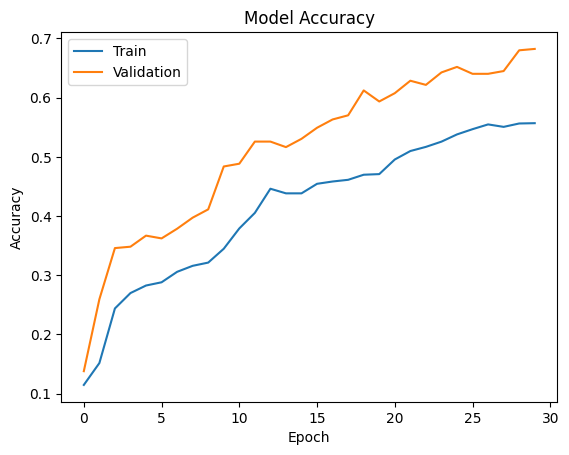

In [28]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Across 30 epochs:

* The training accuracy gradually improved to close to 65%.
* The model's performance on the validation accuracy begins to be volatile but gradually improving around the 10th epoch
* The validation accuracy at his plateau fluctuates between 50 - 65%
* This performance signifies that the model is overfitting the training data and would not improve from additional epochs.

**Evaluate the model on test data**

In [29]:
accuracy = model1.evaluate(X_test_normalized, y_test_encoded, verbose=2)    # Complete the code to evaluate the model on test data

15/15 - 1s - 70ms/step - accuracy: 0.6716 - loss: 1.1074


* The model achieved 70.11% and a loss of 1.0753 on the test set.

**Plotting the Confusion Matrix**

In [30]:
# Here we would get the output as probablities for each category
y_pred=model1.predict(X_test_normalized)                          # Complete the code to predict the output probabilities

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


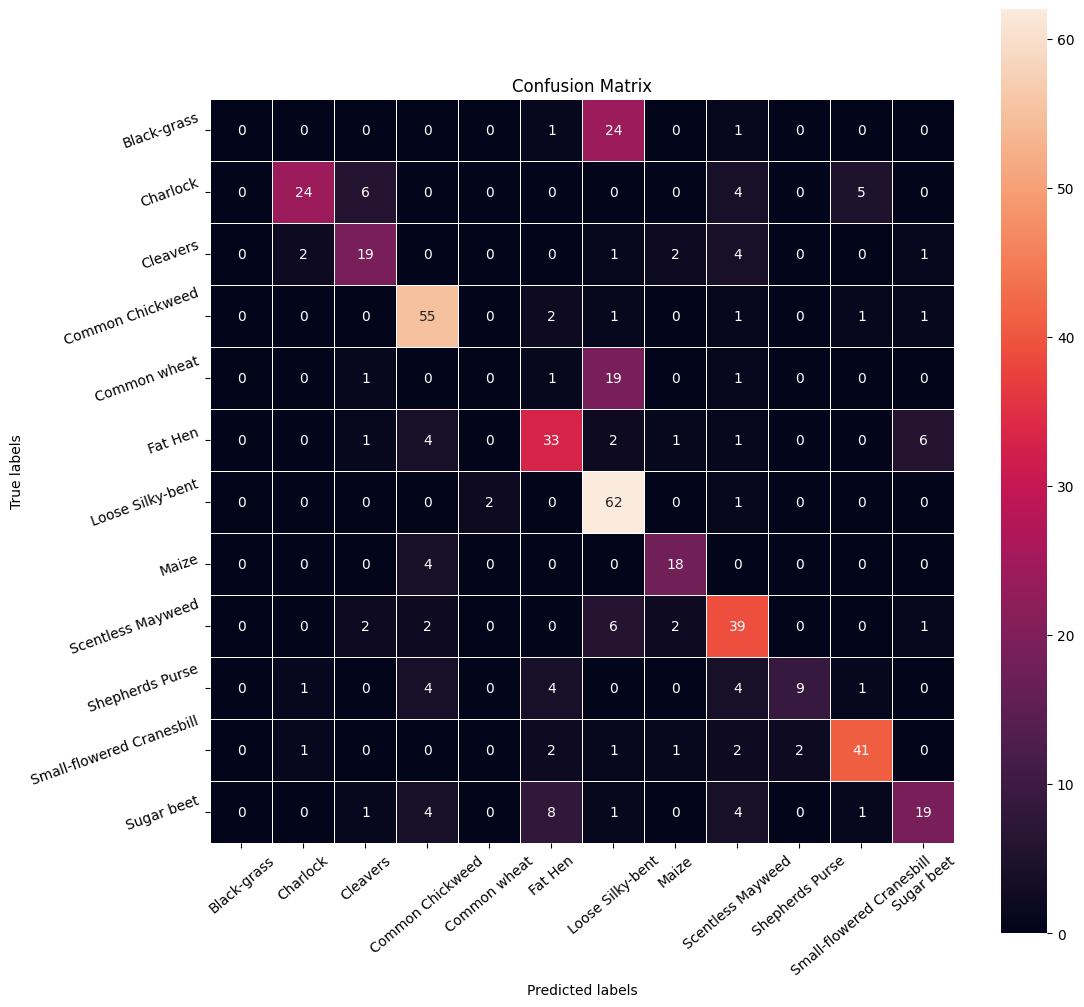

In [31]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined in tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)              # To plot the confusion matrix
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=40)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=20)
plt.show()

* We observe that most of the classes are predicted correctly, but the misclassification occurs mostly with the black grass and loose silky-bent 24, and also common wheat which is sometimes confused with Loose Sikly-bent 19, also the model is not predicting instances of black grass.

**Plotting Classification Report**

In [32]:
from sklearn import metrics

# Plotting the classification report
cr=metrics.classification_report(y_test_arg,y_pred_arg)     # To plot the classification report
print(cr)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.86      0.62      0.72        39
           2       0.63      0.66      0.64        29
           3       0.75      0.90      0.82        61
           4       0.00      0.00      0.00        22
           5       0.65      0.69      0.67        48
           6       0.53      0.95      0.68        65
           7       0.75      0.82      0.78        22
           8       0.63      0.75      0.68        52
           9       0.82      0.39      0.53        23
          10       0.84      0.82      0.83        50
          11       0.68      0.50      0.58        38

    accuracy                           0.67       475
   macro avg       0.59      0.59      0.58       475
weighted avg       0.63      0.67      0.63       475



* The overall accuracy of the model is 67%

* Precision is much higher at 75% for class 7 showing the model is more precise in certain categories.

* Recall: There is a higher reacall of 95% at class 6, meaning that the model correctly identifies most of the images from class 6.

* F1-Score: F1-score of 0.83 at class 10 showing good performance overall.

* Conclusion: The model appears to perform well for some classes (eg, class 10) but struggles with others (eg, class 0) It might be worthwhile to investigate why certain classes are more challenging for the model and consider strategies to improve performance, such as adjusting class weights, collecting more data for under-represented classes, or fine-tuning the model architecture.


## Model Performance Improvement

**Reducing the Learning Rate:**

**ReduceLRonPlateau()** is a function that will be used to decrease the learning rate by some factor, if the loss is not decreasing for some time. This may start decreasing the loss at a smaller learning rate. There is a possibility that the loss may still not decrease. This may lead to executing the learning rate reduction again in an attempt to achieve a lower loss.

In [33]:
# To monitor val_accuracy
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)


### **Model 2 - CNN Model with Data Augmentation**

In [34]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [35]:
# To set the rotation_range to 20
train_datagen = ImageDataGenerator(
                              rotation_range=20,
                              fill_mode='nearest'
                              )

In [36]:
# Intializing a sequential model
model2 = Sequential()

# To add the first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension images
model2.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# To add max pooling to reduce the size of output of first conv layer
model2.add(MaxPooling2D((2, 2), padding = 'same'))


model2.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model2.add(MaxPooling2D((2, 2), padding = 'same'))
model2.add(BatchNormalization())

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model2.add(Flatten())

# Adding a fully connected dense layer with 16 neurons
model2.add(Dense(16, activation='relu'))

# To add dropout with dropout_rate=0.3
model2.add(Dropout(0.3))
# To add the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem
model2.add(Dense(12, activation='softmax'))

# To initialize Adam Optimimzer
opt=Adam()
# To Compile model
model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 16, 16, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │         131,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12)                  │             204 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 151,676 (592.48 KB)

 Trainable params: 151,612 (592.23 KB)

 Non-trainable params: 64 (256.00 B)

* The model has a resonable number of parameters for a relatively small image dataset (64x64 images).
* With 2 convolutional layers followed by batch normalization, dense layers, and a dropout layer to prevent overfitting.
* The total parameters are modest (less than 600KB), thus this model is feasible for training.

<b> Fitting the model on the train data

In [37]:
# To fit the model on train data with batch_size=64 and epochs=30
# Epochs
epochs = 30
# Batch size
batch_size = 64

history = model2.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       shuffle=False),
                                       epochs=epochs,
                                       steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                                       validation_data=(X_val_normalized,y_val_encoded),
                                       verbose=1,callbacks=[learning_rate_reduction])

Epoch 1/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 14s 153ms/step - accuracy: 0.1669 - loss: 2.4040 - val_accuracy: 0.1495 - val_loss: 2.4184 - learning_rate: 0.0010
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2969 - loss: 2.0289 - val_accuracy: 0.1963 - val_loss: 2.4233 - learning_rate: 0.0010
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.3762 - loss: 1.8459 - val_accuracy: 0.2407 - val_loss: 2.3470 - learning_rate: 0.0010
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4062 - loss: 1.6624 - val_accuracy: 0.2570 - val_loss: 2.3478 - learning_rate: 0.0010
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.4555 - loss: 1.6475 - val_accuracy: 0.5350 - val_loss: 2.1978 - learning_rate: 0.0010
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4688 - loss: 1.6653 - val_accuracy: 0.5257 - val_loss: 2.1826 - learning_rate: 0.0010
Epoch 7/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.4980 - loss: 1.5037 - val_accu

**Model Evaluation on Training Data**

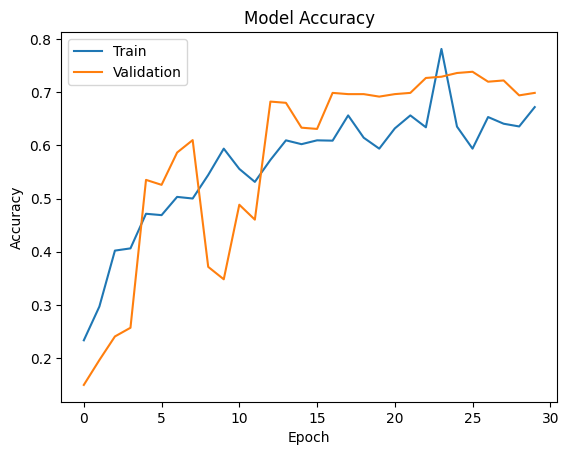

In [38]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Across 30 epochs:
* The training accuracy gradually improved close to 70%.
* From the 5th epoch, the model's performance on the validation accuracy shows sporadic improvement but is highly volatile.
* This performance signifies that the model is overfitting the training data and would not improve from additional epochs.

**Evaluate the model on test data**

In [39]:
accuracy = model2.evaluate(X_test_normalized, y_test_encoded, verbose=2)  # Complete the code to evaluate the model on test data

15/15 - 1s - 51ms/step - accuracy: 0.7116 - loss: 0.8947


* The model achieved 73.68% and a loss of 0.7925 on the test set.

**Plotting the Confusion Matrix**

In [40]:
# To obtain the output probabilities
y_pred=model2.predict(X_test_normalized)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


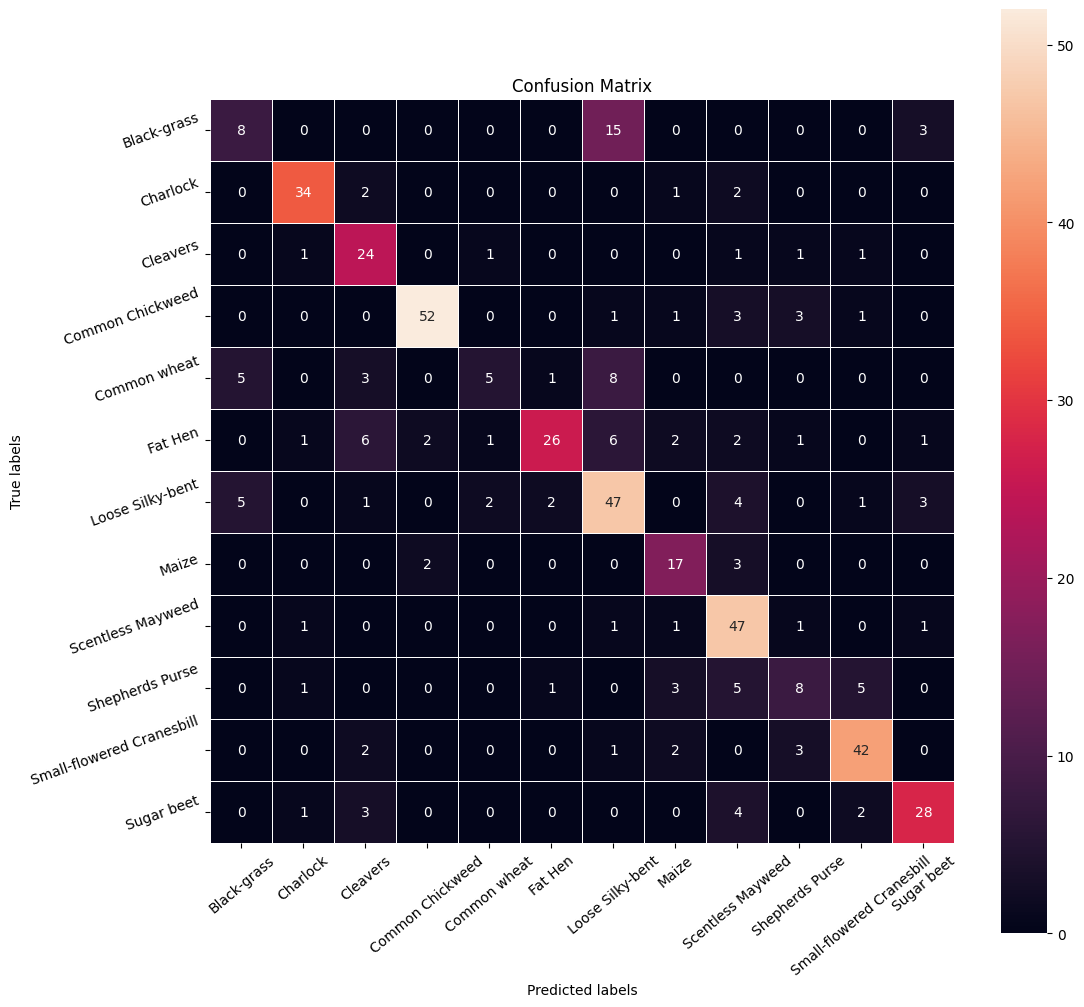

In [41]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined in tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)     # To obatin the confusion matrix
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=40)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=20)
plt.show()

* We observe that most of the classes are predicted correctly, but the misclassification occurs mostly with the back grass and loose silky-bent 15, and also common wheat which is sometimes confused with Loose Silky-bent 8.

**Plotting Classification Report**

In [42]:
# Plotting the classification report
cr=metrics.classification_report(y_test_arg,y_pred_arg)     # To plot the classification report
print(cr)

              precision    recall  f1-score   support

           0       0.44      0.31      0.36        26
           1       0.87      0.87      0.87        39
           2       0.59      0.83      0.69        29
           3       0.93      0.85      0.89        61
           4       0.56      0.23      0.32        22
           5       0.87      0.54      0.67        48
           6       0.59      0.72      0.65        65
           7       0.63      0.77      0.69        22
           8       0.66      0.90      0.76        52
           9       0.47      0.35      0.40        23
          10       0.81      0.84      0.82        50
          11       0.78      0.74      0.76        38

    accuracy                           0.71       475
   macro avg       0.68      0.66      0.66       475
weighted avg       0.72      0.71      0.70       475



* The model achieves 70% accuracy on the training data and 71% accuracy on the testing data.
* We can observe from the classification report and the heat map that the model performs better on identifying less well-represented classes in the training data.

* The model achieves 74% accuracy on the test set, meaning 74% of the predictions are correct across all classes.
* Macro average F1-score is 0.67 meaning this averages the precision, recall and F1-score across all classes.
* F1-score of 0.72 means that the model performs better on larger classes.

## Model 3

In [104]:
# Clearing backend
backend.clear_session()

In [99]:
# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [105]:
# initialize the model as sequential
model3 = Sequential()

In [106]:
# start with a conv layer
model3.add(Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(64,64,3)))
model3.add(MaxPooling2D(2,2))
model3.add(BatchNormalization())
model3.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model3.add(MaxPooling2D(2,2))
model3.add(BatchNormalization())
model3.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model3.add(MaxPooling2D(2,2))
model3.add(BatchNormalization())

# flatten
model3.add(Flatten())

# ANN layers
model3.add(Dense(64, activation='relu'))
model3.add(Dropout((0.25)))
model3.add(Dense(32, activation='relu'))
model3.add(Dropout((0.25)))
model3.add(Dense(16, activation='relu'))

#output layer
model3.add(Dense(12, activation='softmax'))

model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 16)            │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 12)                  │             204 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 93,740 (366.17 KB)

 Trainable params: 93,516 (365.30 KB)

 Non-trainable params: 224 (896.00 B)

In [107]:
from keras.callbacks import ModelCheckpoint, EarlyStopping


In [108]:
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=5,) #restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, mode='auto', min_delta=0.00001)
callbacks = (early_stop, reduce_lr)

history_3 = model3.fit(X_train_normalized, y_train_encoded,
                    validation_data=(X_val_normalized, y_val_encoded),
                    epochs=50,
                    batch_size=32,
                    verbose=2,
                    callbacks=callbacks
)

Epoch 1/50
121/121 - 16s - 133ms/step - accuracy: 0.2241 - loss: 2.2875 - val_accuracy: 0.1379 - val_loss: 3.4938 - learning_rate: 0.0010
Epoch 2/50
121/121 - 1s - 8ms/step - accuracy: 0.4234 - loss: 1.7112 - val_accuracy: 0.1379 - val_loss: 5.3841 - learning_rate: 0.0010
Epoch 3/50
121/121 - 1s - 7ms/step - accuracy: 0.5071 - loss: 1.4341 - val_accuracy: 0.1379 - val_loss: 5.8580 - learning_rate: 0.0010
Epoch 4/50
121/121 - 1s - 11ms/step - accuracy: 0.5875 - loss: 1.1793 - val_accuracy: 0.1495 - val_loss: 5.2179 - learning_rate: 5.0000e-04
Epoch 5/50
121/121 - 1s - 7ms/step - accuracy: 0.6293 - loss: 1.0803 - val_accuracy: 0.4136 - val_loss: 1.8645 - learning_rate: 5.0000e-04
Epoch 6/50
121/121 - 1s - 10ms/step - accuracy: 0.6564 - loss: 0.9959 - val_accuracy: 0.5654 - val_loss: 1.3445 - learning_rate: 5.0000e-04
Epoch 7/50
121/121 - 1s - 10ms/step - accuracy: 0.6878 - loss: 0.9401 - val_accuracy: 0.6893 - val_loss: 0.9822 - learning_rate: 5.0000e-04
Epoch 8/50
121/121 - 1s - 7ms/ste

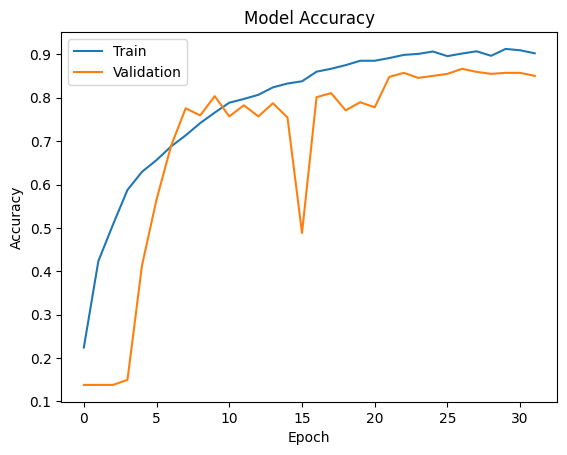

In [110]:
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [111]:
accuracy = model3.evaluate(X_test_normalized, y_test_encoded, verbose=2)


15/15 - 1s - 79ms/step - accuracy: 0.8484 - loss: 0.5352


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


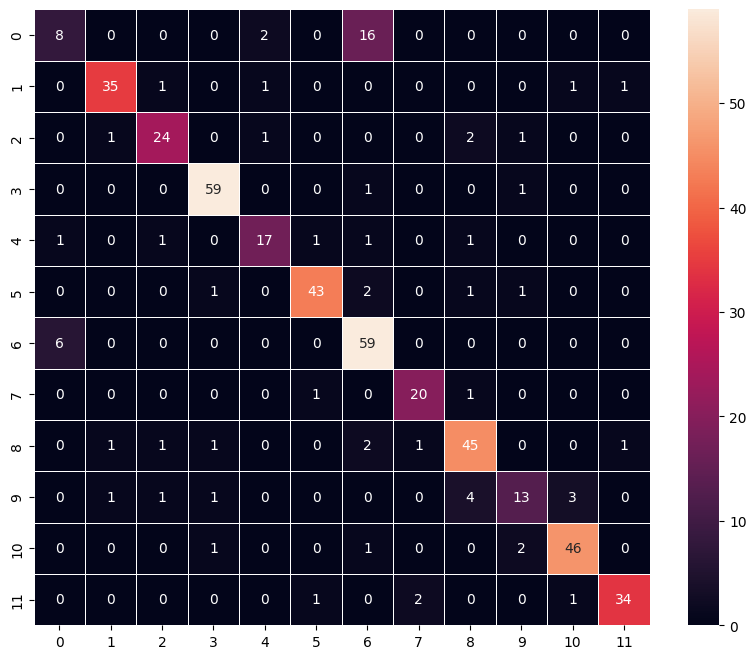

In [112]:
y_pred4 = model3.predict(X_test_normalized)
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred4_arg=np.argmax(y_pred4,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred4_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

* We observe that most of the classes are predicted correctly, but the misclassification occurs mostly with the black grass and loose silky-bent 16.

In [113]:
cr3 =metrics.classification_report(y_test_arg,y_pred4_arg, output_dict=True)
f1_3 = cr3['macro avg']['f1-score']
acc_3 = cr3['accuracy']
print('f1-score:',f1_3)
print('Accuracy:', acc_3)


f1-score: 0.8169389333285507
Accuracy: 0.848421052631579


In [114]:
cr3 =metrics.classification_report(y_test_arg,y_pred4_arg)
print(cr3)

              precision    recall  f1-score   support

           0       0.53      0.31      0.39        26
           1       0.92      0.90      0.91        39
           2       0.86      0.83      0.84        29
           3       0.94      0.97      0.95        61
           4       0.81      0.77      0.79        22
           5       0.93      0.90      0.91        48
           6       0.72      0.91      0.80        65
           7       0.87      0.91      0.89        22
           8       0.83      0.87      0.85        52
           9       0.72      0.57      0.63        23
          10       0.90      0.92      0.91        50
          11       0.94      0.89      0.92        38

    accuracy                           0.85       475
   macro avg       0.83      0.81      0.82       475
weighted avg       0.84      0.85      0.84       475



The overall accuracy of the model is reported as 85%, indicating the proportion of correctly classified instances out of the total.

In summary, the classification report provides a detailed evaluation of the model's performance for each class and overall. The macro and weighted averages offer insights into the model's generalization across all classes, considering both class-wise performance and class imbalance. An overall accuracy of 85% suggests that the model is performed well.

### **Final Model**

Model 3 has higher accuracies across all 3 models, indicating better overall performance. This suggest that Model 2 is likely a more robust and effective model.

There is less misclassification when it comes to the lables in model 3, model 3 has strong performance for most of the classes Training Accuracy: 0.85, Validation Accuracy: 0.84 and Test Accuracy: 0.85

The model demonstrates strong performance across multiple metrics (precision, recall, f1-score).

### Visualizing the prediction

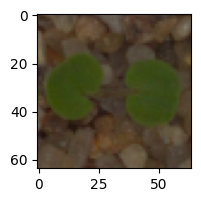

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted Label ['Small-flowered Cranesbill']
True Label Small-flowered Cranesbill


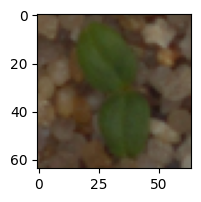

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted Label ['Cleavers']
True Label Cleavers


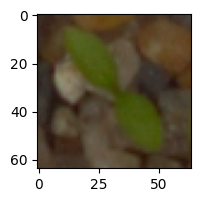

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted Label ['Common Chickweed']
True Label Common Chickweed


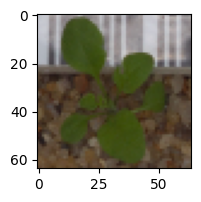

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted Label ['Shepherds Purse']
True Label Shepherds Purse


In [118]:

# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[2])
plt.show()
## To predict the test data using the final model selected
print('Predicted Label', enc.inverse_transform(model3.predict((X_test_normalized[2].reshape(1,64,64,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[2])                                               # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[33])
plt.show()
## To predict the test data using the final model selected
print('Predicted Label', enc.inverse_transform(model3.predict((X_test_normalized[33].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[33])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[59],)
plt.show()
## To predict the test data using the final model selected
print('Predicted Label', enc.inverse_transform(model3.predict((X_test_normalized[59].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[59])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[36])
plt.show()
## To predict the test data using the final model selected
print('Predicted Label', enc.inverse_transform(model3.predict((X_test_normalized[36].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[36])                                              # using inverse_transform() to get the output label from the output vector

## Actionable Insights and Business Recommendations

* These models can be further improved by training with different filter sizes and different number of filters
* Different combinations of hyperparameters in the convolutional layers can be tested to improve the model performance, such as through a randomized grid search
* Other transfer learning architectures can also be used to train the CNN model and these models can be used for classification.

* Recommendation I recommend using model 3. It is accurate to between 80 and 85%, which will drastically reduce the amount of manual classification work for farmers. This model has the added benefit of requiring little image preprocessing and no costly data augmentation.

In [122]:
!jupyter nbconvert --to html Plant_Seedling_Classification_using_Computer_Vision-2.ipynb

[NbConvertApp] Converting notebook Plant_Seedling_Classification_using_Computer_Vision-2.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 14 image(s).
[NbConvertApp] Writing 2331193 bytes to Plant_Seedling_Classification_using_Computer_Vision-2.html


_____